In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

In [18]:
image = cv2.imread('sar_1 (1).jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [19]:
def homo_average(img, mask, point, T):
    masked_region = img[mask > 0]
    if len(masked_region) == 0:
        return False
    av_val = masked_region.mean()
    
    if abs(av_val - img[point]) <= T:
        return True
    
    return False

In [20]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1  
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

In [21]:
seed_point = (250, 250)  
r = 4  
T = 18  

In [22]:
res = region_growing(image_gray, seed_point, homo_average, r, T)

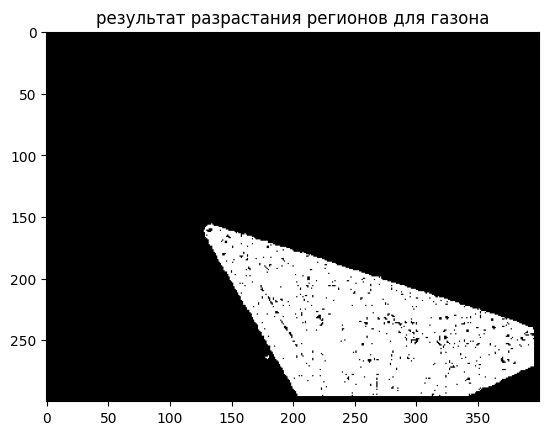

In [23]:
plt.imshow(res, cmap="gray")
plt.title("результат разрастания регионов для газона")
plt.show()

2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

In [24]:
def homo_median(img, mask, point, T):
    masked_region = img[mask > 0]
    if len(masked_region) == 0:
        return False
    median_val = np.median(masked_region)
    
    if abs(median_val - img[point]) <= T:
        return True
    
    return False

In [25]:
mask_average = region_growing(image_gray, seed_point, homo_average, 4, 25)
mask_median = region_growing(image_gray, seed_point, homo_median, 4, 25)

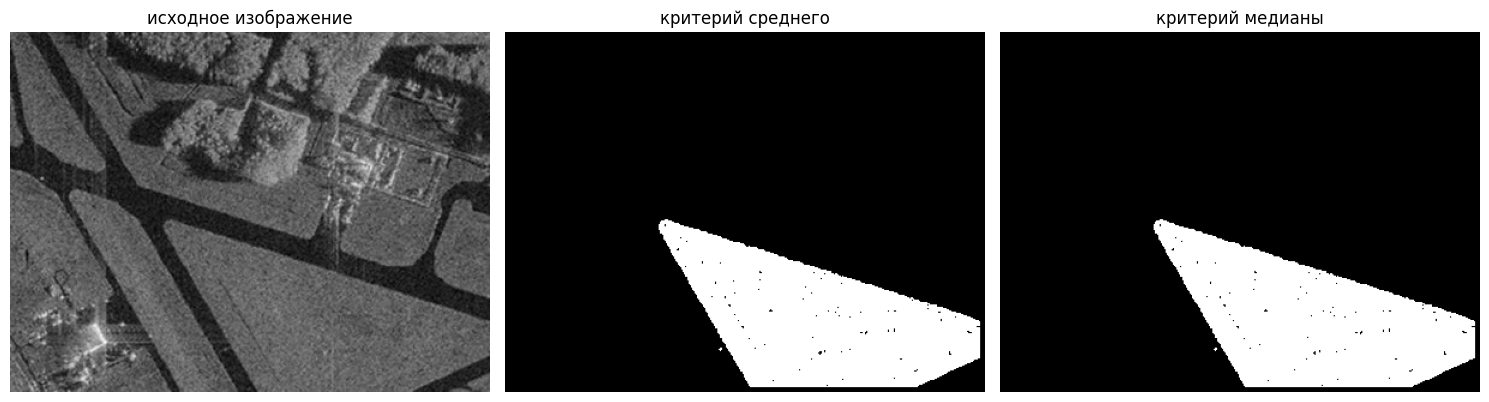

площадь (среднее): 20771
площадь (медиана): 20775


In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('исходное изображение')
axes[0].axis('off')

axes[1].imshow(mask_average, cmap='gray')
axes[1].set_title('критерий среднего')
axes[1].axis('off')

axes[2].imshow(mask_median, cmap='gray')
axes[2].set_title('критерий медианы')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"площадь (среднее): {np.count_nonzero(mask_average)}")
print(f"площадь (медиана): {np.count_nonzero(mask_median)}")

3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

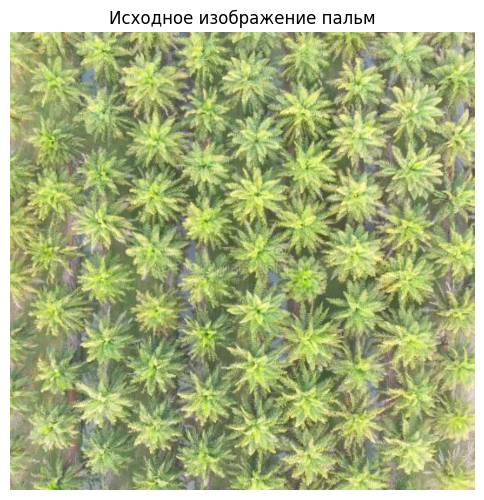

In [27]:
image1 = cv2.imread('palm_1.jpg')
image_rgb1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image_gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6, 6))
plt.imshow(image_rgb1)
plt.title('Исходное изображение пальм')
plt.axis('off')
plt.show()

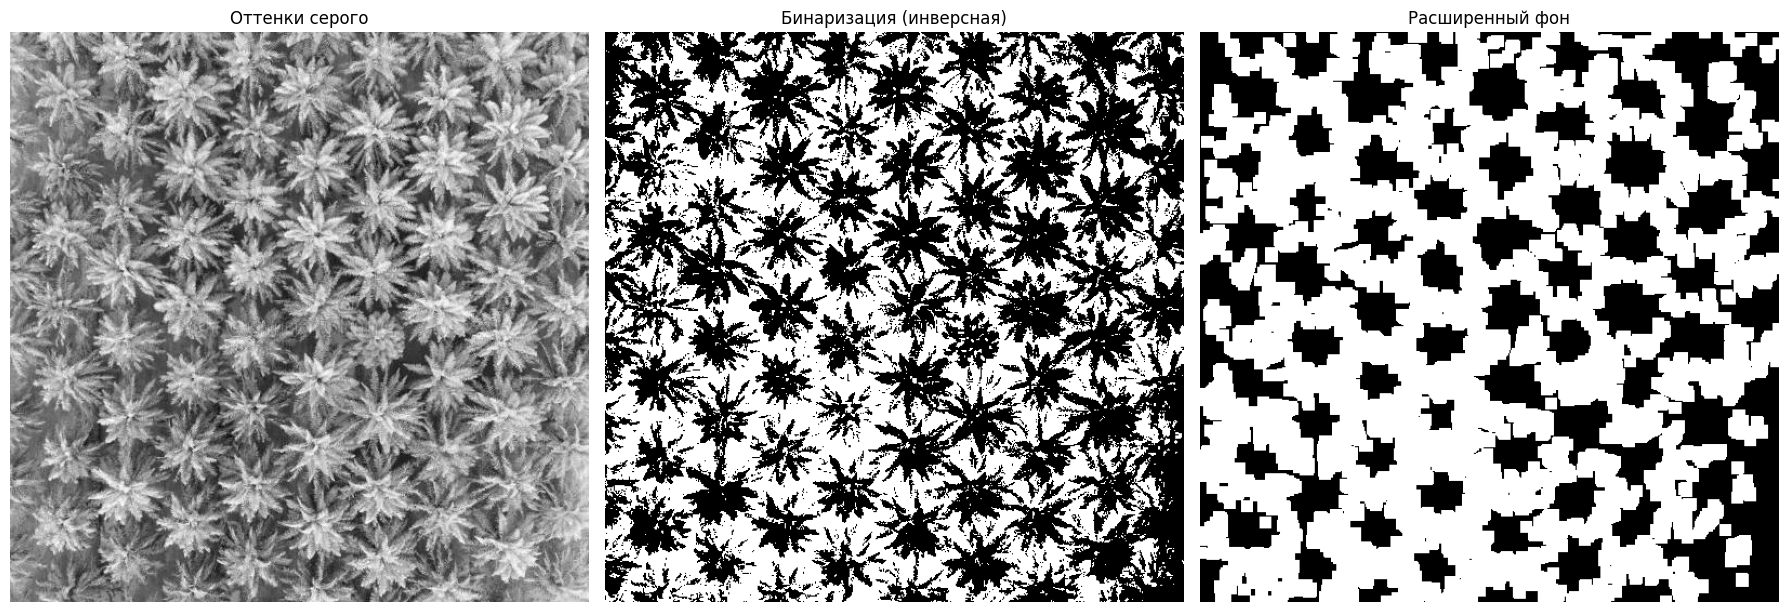

In [28]:
_, binary_inv = cv2.threshold(image_gray1, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary_inv, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(image_gray1, cmap='gray')
axes[0].set_title('Оттенки серого')
axes[0].axis('off')

axes[1].imshow(binary_inv, cmap='gray')
axes[1].set_title('Бинаризация (инверсная)')
axes[1].axis('off')

axes[2].imshow(sure_bg, cmap='gray')
axes[2].set_title('Расширенный фон')
axes[2].axis('off')

plt.tight_layout()
plt.show()

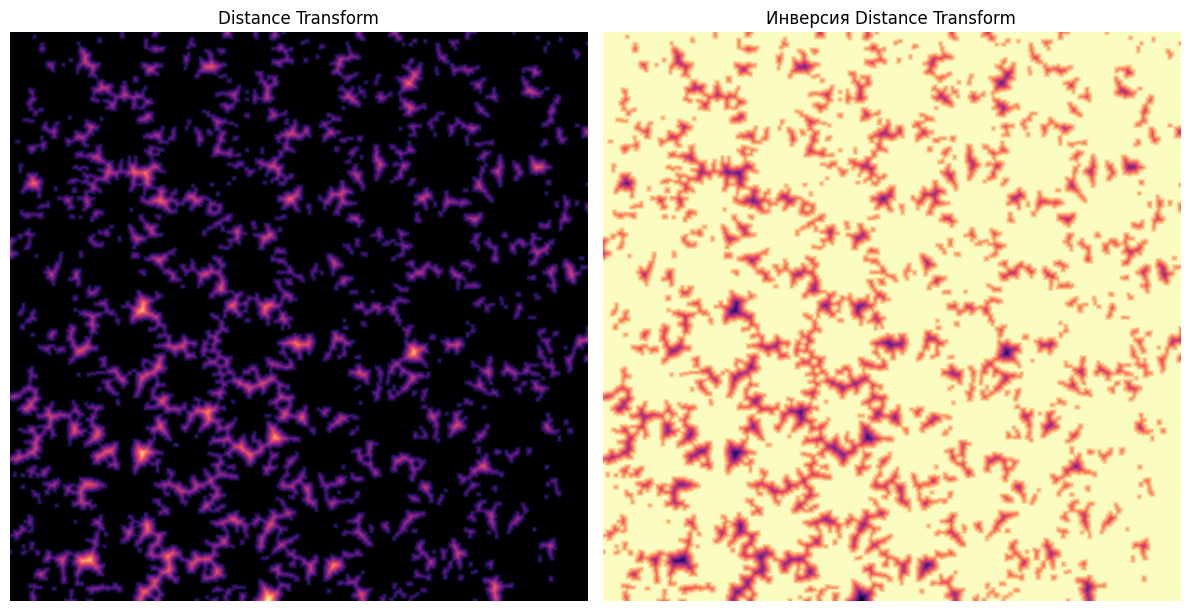

In [29]:
dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
dist_norm = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)
dist_inv = 1.0 - dist_norm

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(dist_norm, cmap='magma')
axes[0].set_title('Distance Transform')
axes[0].axis('off')

axes[1].imshow(dist_inv, cmap='magma')
axes[1].set_title('Инверсия Distance Transform')
axes[1].axis('off')

plt.tight_layout()
plt.show()

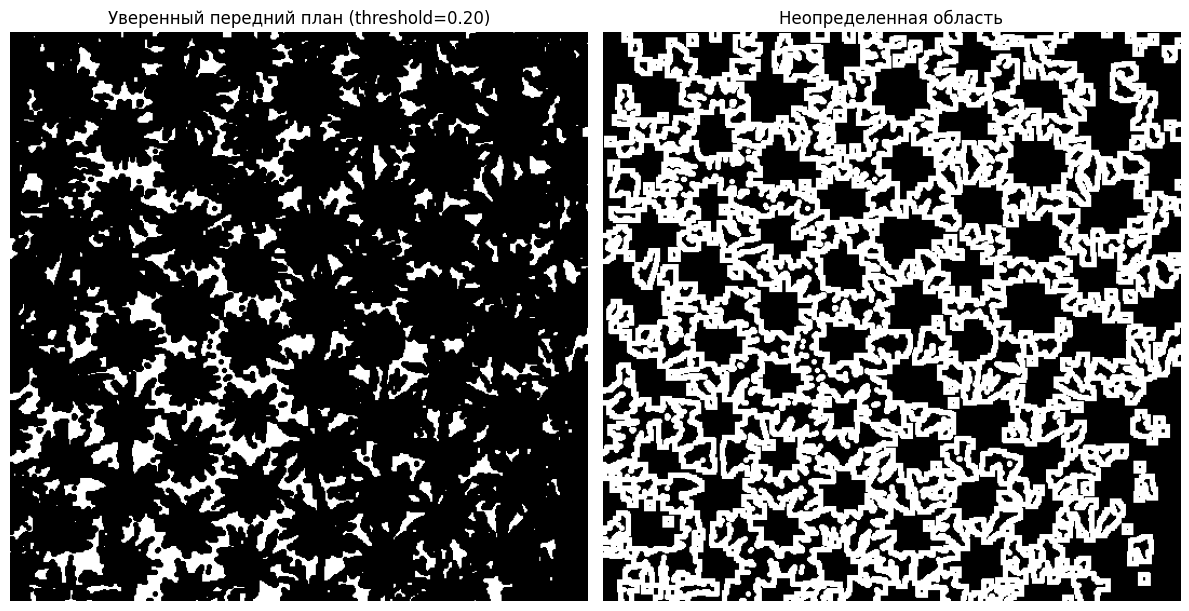

Количество компонентов до watershed: 433


In [30]:
thresholds = np.linspace(0.55, 0.2, 8)
desired_min_palms = 80
sure_fg = None
selected_threshold = thresholds[-1]
palm_count_pre = 0

for thr in thresholds:
    _, candidate = cv2.threshold(dist_inv, thr, 1.0, cv2.THRESH_BINARY)
    candidate_u8 = np.uint8(candidate * 255)
    candidate_count = cv2.connectedComponents(candidate_u8)[0] - 1
    if candidate_count >= desired_min_palms:
        sure_fg = candidate_u8
        selected_threshold = thr
        palm_count_pre = candidate_count
        break

if sure_fg is None:
    _, candidate = cv2.threshold(dist_norm, thresholds[-1], 1.0, cv2.THRESH_BINARY)
    sure_fg = np.uint8(candidate * 255)
    palm_count_pre = cv2.connectedComponents(sure_fg)[0] - 1

unknown = cv2.subtract(sure_bg, sure_fg)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(sure_fg, cmap='gray')
axes[0].set_title(f'Уверенный передний план (threshold={selected_threshold:.2f})')
axes[0].axis('off')

axes[1].imshow(unknown, cmap='gray')
axes[1].set_title('Неопределенная область')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print('Количество компонентов до watershed:', palm_count_pre)

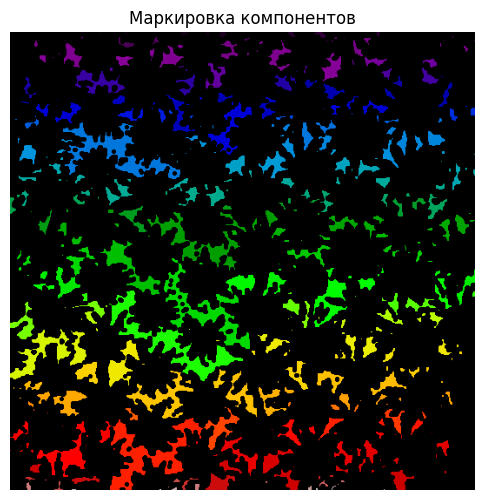

In [31]:
num_labels, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

plt.figure(figsize=(6, 6))
plt.imshow(markers, cmap='nipy_spectral')
plt.title('Маркировка компонентов')
plt.axis('off')
plt.show()

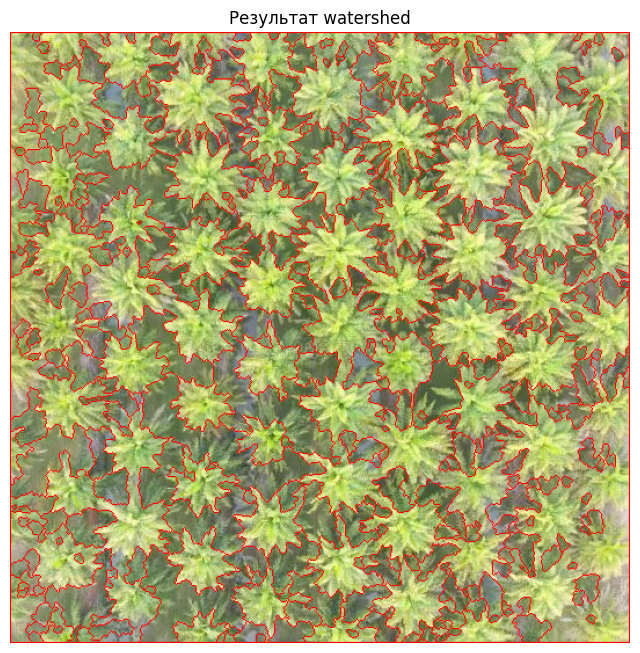

Количество пальм после watershed: 425


In [32]:
markers = cv2.watershed(image1, markers)
segmentation = image_rgb1.copy()
segmentation[markers == -1] = [255, 0, 0]

unique_markers = np.unique(markers)
palm_labels = unique_markers[unique_markers > 1]
palm_count = len(palm_labels)

plt.figure(figsize=(8, 8))
plt.imshow(segmentation)
plt.title('Результат watershed')
plt.axis('off')
plt.show()

print('Количество пальм после watershed:', palm_count)